![Title](Images/cisco.png)

# Lab - Advanced Data Visualization 

### Objectives
* **Part 1: Prepare the data**
* **Part 2: Visualize the data**

### Scenario/Background
In this lab, you will learn how to combine an `SQLite` database, `JSON` files, and `pandas` `DataFrame`s. You will interface with a wrapper for the library `folium`, that enables you to plot data on a geographical map. You will produce a map of the United Kingdom divided in areas, each colored in a shade that is proportional to the internet speed, a very powerful way of understanding the data. With such a map, it will be very clear how internet speed vaires across England. You will learn how to find and fix problems in the data. 

### Required Resources
* 1 PC with Internet access
* Raspberry Pi version 2 or higher
* Python libraries: `pandas`, `numpy`, `sqlite3`, `matplotlib`, `folium_utils`
* Datafiles: LA_Poligons.json

## Part 1: Prepare the data

To use the `folium` library, we will modify the data to get it in the right format. At the moment, the data is in an SQLite database and we want to have it in a `pandas` `DataFrame`. A few more cahnges also need to be made.

##### Step 1: Get the data and store it in a `pandas` `DataFrame`.

First, we need to get the data. We are going to connect to the InternetSpeed database.

###### a) Import the libraries.
- `pandas`
- `numpy`
- `sqlite3`
- `pyplot` (and use the style fivethirtyeight, or another one if you prefer)
- `folium_utils`

In [17]:
# Code Cell 1
# import ... 
# ...
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import folium_utils
plt.style.use('fivethirtyeight')
%matplotlib inline

###### b) Connect to the database.


Now we need to go back to the database we created and populated in the second lab of Chapter 2:

    ./Data/InternetSpeed.db
A copy of the database is stored in your Chapter 5 folder. Connect to the database.    

In [18]:
# Code Cell 2

# Create the connection to the database
conn = sqlite3.connect('/content/InternetSpeed.db')
# Create a cursor
cur = conn.cursor()


The database contains the table `average_speed` with the average ping time, upload speed, and download speed for the different Local Authorities in England. The first step in this lab is to read the data in the table into a `pandas` `DataFrame` with the function `.read_sql()`. 

This function needs a string containing the query to be executed and the variable that contains the connection to the database (see http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql.html for details). Assuming the query is stored in the variable `query`, the call

    pd.read_sql(query)

will return a `pandas` `DataFrame`.

###### c) Store the data in a `DataFrame`.
1. Write the query to select all the data in the table `average_speed`.
2. Use `pandas` to put the results of the query into a `DataFrame`.


In [19]:
# Code Cell 3
# Create a query to select all the data in the table average_speed
query = 'SELECT * FROM average_speed'

# Read the the data from the table into a DataFrame.
df = pd.read_sql(query, conn)


###### Step 2: Clean the data.

Using the `pandas` functions learned so far, explore the produced `Dataframe` and remove any unwanted columns.

###### a) Explore the data.
Print the first few rows of the `DataFrame` df.

In [20]:
# Code Cell 4
df.head()


,index,Area,Average_p,Average_u,Average_d
0,0,E07000188,8.451897,21.114114,51.967713
1,1,E07000101,8.317833,20.733028,51.709226
2,2,E09000030,8.983481,22.469438,54.412001
3,3,E09000031,8.956481,22.353593,55.138017
4,4,E09000032,9.144285,22.859003,55.962499


The column `index` is not needed for this exercise. 

###### b) Clean the data.
Drop the column `index` from the `DataFrame`. Remember that the change is effective if the parameter `inplace` is set to True or if you assign the modified `DataFrame` to a new `DataFrame`. 

In [21]:
# Code Cell 5
df.drop('index', inplace = True, axis=1)

print(df.shape)
df.head()

(326, 4)


,Area,Average_p,Average_u,Average_d
0,E07000188,8.451897,21.114114,51.967713
1,E07000101,8.317833,20.733028,51.709226
2,E09000030,8.983481,22.469438,54.412001
3,E09000031,8.956481,22.353593,55.138017
4,E09000032,9.144285,22.859003,55.962499


##### Step 3: Learn about `JSON` files.

The map will be created by drawing the borders of each Local Authority and coloring them according to a colormap. The color coded map will indicate the relative Internet speed of an area with respect to other areas. 

Each area is represented by a polygon, which will be drawn on our map. The edges of each polygon represent the borders of each Local Authority. A `JSON` file is provided, containing the coordinates of the borders of each Local Authority.  

`JSON` is a popular alternative to XML, and it is a format used to store and exchange data (to learn more about `JSON` see  http://www.w3schools.com/js/js_json_intro.asp).

###### a) Open and observe the file.
    
    LA_poligons.json
    
Similar to the functionalities provided for reading `csv` files and `SQL` tables, it is possible to read the content of a `JSON` file in a `pandas` `DataFrame` with the method `read_json()`. This method takes an input string containing the path to the file we intend to read (see this documentation for more details: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html).

###### b) Read `LA_poligons.json` into a `pandas` `DataFrame`, and then visualize the first few rows. 

In [22]:
# Code Cell 6
# Read the JSON file into a DataFrame
la_json = pd.read_json('/content/LA_poligons.json')

# Visualize the first rows of la_json DataFrame
la_json.head()

,LA_code,geometry
0,E06000001,"{u'type': u'MultiPolygon', u'coordinates': [[[..."
1,E06000002,"{u'type': u'MultiPolygon', u'coordinates': [[[..."
2,E06000003,"{u'type': u'MultiPolygon', u'coordinates': [[[..."
3,E06000004,"{u'type': u'MultiPolygon', u'coordinates': [[[..."
4,E06000005,"{u'type': u'Polygon', u'coordinates': [[[-1.63..."


The information contained in this `Dataframe` will be used later in the visualization.

##### Step 4: Average the ping speed.
For each map that will be produced, only one of the three Internet speed indicators can be visualized (average ping, upload speed, or download speed). In this lab, the focus will be on the average ping speed, but the student is encouraged to repeat the exercise to visualize upload and download speeds.

###### a) Prepare the data.
Create a new `pandas` `DataFrame` that contains only two columns: `Area` and `Average_p`, selecting them from the `DataFrame` that contains the `InternetSpeed` database data. 
Now rename the column `Area` to `LA_code`, using the method `rename()`.
You will need to pass to the method the field `columns` with this code:

    columns={'Area':'LA_code'}
    
1. Create the new `DataFrame`.
2. Rename the columns.
3. Display the first few lines of the new `DataFrame`.

In [25]:
# Code Cell 7
dfp = df[['Area' , 'Average_p']]

dfp=dfp.rename(columns={"Area":"LA_code"})
dfp.head()


,LA_code,Average_p
0,E07000188,8.451897
1,E07000101,8.317833
2,E09000030,8.983481
3,E09000031,8.956481
4,E09000032,9.144285


By default, `folium` uses only 6 different colors to define a colormap. Rather than defining a custom colormap, the data of the Internet speed indicator of interest will be divided into 6 bins, and each bin will be associated to a  different color. The bins must be carefully defined, in order to maximize the differences between the different areas.
To choose the bins, it's a good idea to have a look at the range of the data. 

So far, the columns of a `pandas` `DataFrame` have been accessed in the following way:

    df['Name_of_the_column']

An alternative way to do so is:

    df.Name_of_the_column

In [27]:
# Code Cell 8
print(dfp.Average_p.min())
print(dfp.Average_p.max())

0.0
11.999447541819524


The ping time is roughly contained in the interval 0-12. If the bins are chosen to be [0, 10, 20, 30, 40, 50], all the data would fall in the first bin and all the areas would be represented with the first color. A good starting point is to take the range in which the data lives and divide it in six different parts.

To create the bins, use the `numpy` method `arange()`. This method takes as input the minimum value of the range, the maximum value of the range, and the step. If 6 bins in the range 1 to 12 are required, the function call would look like: 

    np.arange(1, 12, (12-1)/6)

###### b) Select good bins for visualization.
Create a range of six values that goes from the minimum to the maximum value of the average ping speed and cast it to a list (`list(p_bins)`).

In [28]:
# Code Cell 9
p_bins = np.arange(dfp.Average_p.min(), dfp.Average_p.max(), (dfp.Average_p.max()-dfp.Average_p.min())/6)

p_bins = list(p_bins)

print(p_bins)

[0.0, 1.9999079236365873, 3.9998158472731746, 5.999723770909762, 7.999631694546349, 9.999539618182936]


## Part 2: Visualize the data

In the folder that contains the code, there is a Python script that contains a few functions that will help produce a data visualization on a map. The main library it uses is `folium`. The library documentation can be found here: https://folium.readthedocs.io/en/latest/).

You can import the functions in a Python script just like any other library.

##### Step 1: Plot the data on a map.

###### a) Learn about the `folium_utils` code.

Open the Python source file `folium_utils.py` and read through it. This script contains a few functions that make use of the `folium` library. 

Can you identify the main function that we are going to use later in the notebook?

This code wraps what a user should write as multiple functions into one with a simpler interface. 

To produce the first map, use the function 
    
        folium_top_x_preds_mapper()
        
contained in `folium_utils`.

In [10]:
import folium_utils

###### b) Call the function `folium_top_x_preds_mapper()` with the following parameters:

- The `Dataframe` that contains the data to be visualized (`dfp`)
- The `Dataframe` that contains the coordinates of the polygons (`la_json`)
- The name of the column on which to merge the two `DataFrames` (LA_code)
- The name of the column that contains the data to plot (Average_p)
- The list containing the limits of the bins (`p_bins`)

In [29]:
# Code Cell 10
# Create the map
mymap = folium_utils.folium_top_x_preds_mapper(dfp,
                                               la_json,
                                               'LA_code',
                                               'Average_p',
                                               p_bins)

mymap

Length mismatch 326 325


What happened? The number of Local Authorities contained in the `DataFrame` `dfp` is bigger than the one contained in the `la_json`. In this case, `folium` would fail to visualize the map, resulting in an error. In `folium_utils`, a check was added to prevent this from happening, and the error message `Length mismatch` is visualized. But why is this happening?

Let's examine the data:

###### c) Plot the column Average_p.

`pandas` provides the basic functionalities to generate plots starting from `DataFrame`s. The plot method on `Series` and `DataFrame` is just a simple wrapper around plt.plot(), but it saves a few lines of code.

You can call the method `plot()` directly on the column you want to plot (`dfp.Average_p.plot()`). 

(See http://pandas.pydata.org/pandas-docs/version/0.18.1/visualization.html for more details about visualization in `pandas`).

<Axes: >

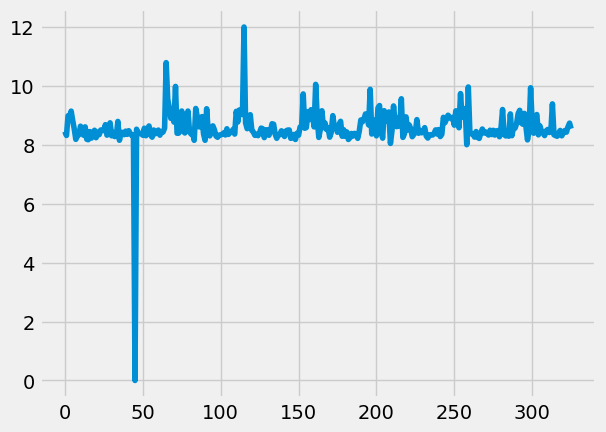

In [30]:
# Code Cell 11
# Plot the column Average_p
dfp.Average_p.plot()


The visualization shows that there is a Local Authority for which the average internet speed is zero. Because it is clearly an anomaly, it is necessary to have a closer look.

###### d) Select the row in which the average speed is zero from the `DataFrame`.

In [31]:
# Code Cell 12
dfp[dfp.Average_p==0]


,LA_code,Average_p
45,DateTime,0.0


DateTime is not the name of a Local Authority: there was a mistake in collecting or storing the data. 

##### Step 2: Fix the data and plot the data on a map again.

###### a) Remove the wrong row from your `DataFrame` 
Remember that for the change to be effective, the flag `inplace` must be set to `True`.

<Axes: >

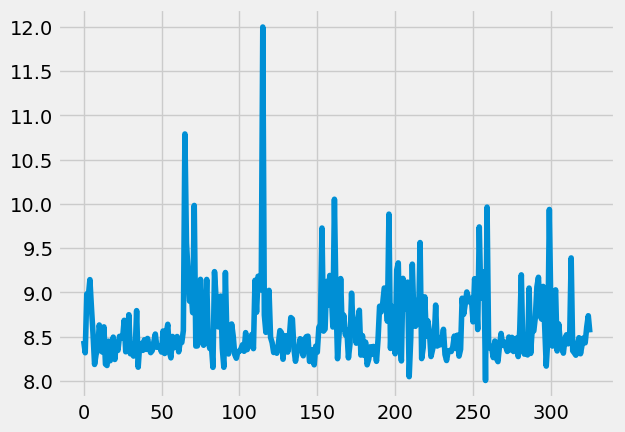

In [32]:
# Code Cell 13
# hint: you can use the index (45) to remove the row
dfp.drop(45,inplace=True)

# Plot here the cleaned data
dfp.Average_p.plot()


Now that the data looks better, we can plot the map again by calling the function in the folium wrapper. We need however, stop for a second and pay attention.


#### Attention!####

If using Chrome, there is currently a limit on the size of map that can be correctly visualized inside a notebook. To this end, we need to limit the size of the `dfp` `DataFrame` to the first 50 rows. The discrepancy in the size of the `dfp` and `la_json` `DataFrame`'s in this case will not cause an error, because `dfp` cannot be bigger than `la_json`, but it can be smaller.
This is operation is not needed if using Firefox.

In [15]:
# resize the dfp DataFrame. This operation is not needed if using Firefox
dfp = dfp.iloc[0:51]


###### b) Call the function  `folium_top_x_preds_mapper()` again , with the same parameters as before.

In [33]:
# Code Cell 14
#mymap = ...?
#mymap
mymap = folium_utils.folium_top_x_preds_mapper(dfp,
                                        la_json,
                                       'LA_code',
                                       'Average_p',
                                        p_bins)
mymap

/usr/local/lib/python3.10/dist-packages/folium/folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


TypeError: ignored

If you have resized the `dfp` `DataFrame`, you should see a map with only one color for the 6 to 8 bin. If you haven't resized it, you should also see the 8 to 10 bin. What happened there?
2
​
3
The value 0 was removed, because it was found to be an anomaly, but the range of the bins for the colormap was not changed.
4
What is the new minimum value for `Average_p`?

In [ ]:
# Code Cell 15
print(dfp.Average_p.min())

It is necessary to repeat the creation of bins with the cleaned dataset. After this, call the function  `folium_top_x_preds_mapper()` to correctly visualize the average ping speed across the UK.
###### c) Recreate the bin range, recreate the map, and visualize it.

In [ ]:
# Code Cell 16

# p_bins = ?

# p_bins = list(?)

#mymap = folium_utils.folium_top_x_preds_mapper(...)
mymap = folium_utils.folium_top_x_preds_mapper(dfp,
                                       la_json,
                                       'LA_code',
                                       'Average_p',
                                        p_bins)
mymap


Much better!

The visualization of the data with a simple line plot lets us spot an error very easily. Sometimes a deeper investigation is needed.

For additional practice, repeat the exercise, but create the visualizations for the columns Average_d (average download speed) and Average_u (average upload speed).

<font size='0.5'>&copy; 2017 Cisco and/or its affiliates. All rights reserved. This document is Cisco Public.<font>